In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing the necesary dependencies
import gc
import h5py
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, AlphaDropout, Activation, add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

In [ ]:
# Defining the function to load data in batches
def load_data_in_batches(base_path, num_parts, batch_size=3000):
    X_combined = np.empty((0, 1024, 2), dtype=np.float32)
    Y_combined = np.empty((0, 24), dtype=np.int32)
    Z_combined = np.empty((0, 1), dtype=np.float32)

    for i in range(num_parts):
        filename = os.path.join(base_path, f'part{i}.h5')
        print(f'Loading {filename}...')
        with h5py.File(filename, 'r') as f:
            sample_num = f['X'].shape[0]
            idx = np.random.choice(range(sample_num), size=batch_size, replace=False)
            idx.sort()
            X_combined = np.vstack((X_combined, f['X'][idx]))
            Y_combined = np.vstack((Y_combined, f['Y'][idx]))
            Z_combined = np.vstack((Z_combined, f['Z'][idx]))

        # Free up memory
        del f
        gc.collect()

    return X_combined, Y_combined, Z_combined

# Load data in smaller batches
base_path = '/content/drive/My Drive/spectrum_sensing/split_parts/'
num_parts = 25
X_combined, Y_combined, Z_combined = load_data_in_batches(base_path, num_parts)

Loading /content/drive/My Drive/spectrum_sensing/split_parts/part0.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part1.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part2.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part3.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part4.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part5.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part6.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part7.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part8.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part9.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part10.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part11.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part12.h5...
Loading /content/drive/My Drive/spectrum_sensing

In [ ]:
# Checking shapes of combined data
print(f'X_combined shape: {X_combined.shape}')
print(f'Y_combined shape: {Y_combined.shape}')
print(f'Z_combined shape: {Z_combined.shape}')

X_combined shape: (75000, 1024, 2)
Y_combined shape: (75000, 24)
Z_combined shape: (75000, 1)


In [ ]:
# Splitting into train and test sets
n_examples = X_combined.shape[0]
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(n_examples), size=n_train, replace=False)
test_idx = list(set(range(n_examples)) - set(train_idx))

X_train = X_combined[train_idx]
Y_train = Y_combined[train_idx]
X_test = X_combined[test_idx]
Y_test = Y_combined[test_idx]

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (52500, 1024, 2)
Y_train: (52500, 24)
X_test: (22500, 1024, 2)
Y_test: (22500, 24)


In [ ]:
# Defining the data augmentation function
def augment_data(X, Y):
    augmented_X, augmented_Y = [], []
    for signal, label in zip(X, Y):
        augmented_X.append(signal)
        augmented_Y.append(label)
        # Add noise
        noise = np.random.normal(0, 0.1, signal.shape)
        augmented_X.append(signal + noise)
        augmented_Y.append(label)
        # Time shifting
        shift = np.random.randint(signal.shape[0])
        augmented_X.append(np.roll(signal, shift, axis=0))
        augmented_Y.append(label)
        # Scaling
        scale = np.random.uniform(0.9, 1.1)
        augmented_X.append(signal * scale)
        augmented_Y.append(label)
    return np.array(augmented_X), np.array(augmented_Y)

# Augment the training data
X_train, Y_train = augment_data(X_train, Y_train)

In [ ]:
# Define class labels
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', '4ASK',
           '16PSK', '64APSK', '128QAM', '128APSK', 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC',
           'OOK', '16QAM']

In [ ]:
# Feature extraction functions
def extract_features(X):
    features = []
    for signal in X:
        # Energy Statistic
        energy = np.sum(np.abs(signal)**2, axis=0)

        # Differential Entropy
        entropy = -np.sum(signal * np.log2(np.abs(signal) + 1e-12), axis=0)

        # Geometric Power
        geometric_power = np.exp(np.mean(np.log(np.abs(signal) + 1e-12), axis=0))

        # Lp-norm (with p=2 for example)
        p_norm = np.sum(np.abs(signal)**2, axis=0)**(1./2)

        features.append(np.hstack((energy, entropy, geometric_power, p_norm)))
    return np.array(features)

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

In [ ]:
print("X_train:", X_train_features.shape)
print("Y_train:", X_test_features.shape)

X_train: (210000, 8)
Y_train: (22500, 8)


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

In [ ]:
# Define the residual stack function
def residual_stack(X, Filters, Seq, max_pool):
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same', activation="relu", name=Seq+"_conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = add([X, X_shortcut])
    X = Activation("relu")(X)
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same', activation="relu", name=Seq+"_conv4", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = add([X, X_shortcut])
    X = Activation("relu")(X)
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

# Create the residual model
def create_residual_model(input_shape, num_classes):
    X_input = Input(input_shape)
    X = Reshape([1, 1024, 2], input_shape=input_shape)(X_input)
    X = residual_stack(X, 32, "ReStk1", False)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    X = residual_stack(X, 32, "ReStk2", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk3", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk4", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk5", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk6", True)
    X = BatchNormalization()(X)
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = AlphaDropout(0.3)(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = AlphaDropout(0.3)(X)
    X = Dense(num_classes, kernel_initializer='he_normal', name="dense3")(X)
    X = Activation('softmax')(X)
    model = Model(inputs=X_input, outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [ ]:
# Create and train the model
input_shape = (1024, 2)
num_classes = len(classes)
model = create_residual_model(input_shape, num_classes)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5),
    LearningRateScheduler(lambda epoch: 1e-3 * 0.1**(epoch // 10))
]

start_time = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch 1/100
1641/1641 [==============================] - 128s 72ms/step - loss: 2.1558 - accuracy: 0.2689 - val_loss: 2.1507 - val_accuracy: 0.3019 - lr: 0.0010
Epoch 2/100
1641/1641 [==============================] - 115s 70ms/step - loss: 1.8594 - accuracy: 0.3415 - val_loss: 2.0883 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 3/100
1641/1641 [==============================] - 114s 69ms/step - loss: 1.7788 - accuracy: 0.3657 - val_loss: 1.8534 - val_accuracy: 0.3829 - lr: 0.0010
Epoch 4/100
1641/1641 [==============================] - 114s 69ms/step - loss: 1.7136 - accuracy: 0.3900 - val_loss: 1.7500 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 5/100
1641/1641 [==============================] - 114s 69ms/step - loss: 1.6547 - accuracy: 0.4082 - val_loss: 1.7113 - val_accuracy: 0.4176 - lr: 0.0010
Epoch 6/100
1641/1641 [==============================] - 114s 69ms/step - loss: 1.6175 - accuracy: 0.4222 - val_loss: 1.6823 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 7/100
1641/1641 [===========

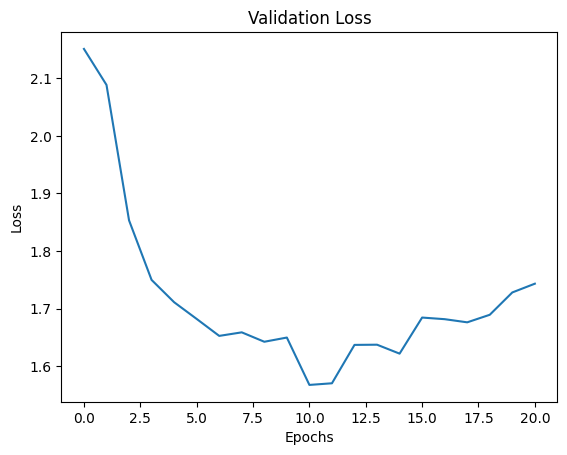

In [ ]:
# Plotting the validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Confusion matrix function
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

22/22 [==============================] - 3s 121ms/step
32PSK 0.7570093457943925
16APSK 0.6442405708460754
32QAM 0.6313559322033898
FM 0.6656472986748216
GMSK 0.6201716738197425
32APSK 0.40789473684210525
OQPSK 0.21139896373056996
8ASK 0.2974413646055437
BPSK 0.6008492569002123
8PSK 0.5387931034482759
AM-SSB-SC 0.4265809217577706
4ASK 0.4014989293361884
16PSK 0.7769709543568465
64APSK 0.4493801652892562
128QAM 0.06414300736067298
128APSK 0.23492723492723494
AM-DSB-SC 0.3581932773109244
AM-SSB-WC 0.18575851393188855
64QAM 0.6870540265035678
QPSK 0.6388888888888888
256QAM 0.5736354273944387
AM-DSB-WC 0.7981462409886715
OOK 0.6396677050882659
16QAM 0.2567287784679089
27/27 [==============================] - 0s 5ms/step
Overall Accuracy -20.0:  0.04398148148148148
28/28 [==============================] - 0s 5ms/step
Overall Accuracy -18.0:  0.030542986425339366
28/28 [==============================] - 0s 5ms/step
Overall Accuracy -16.0:  0.04049493813273341
28/28 [==========================

<ipython-input-71-4fdcc5e9f62c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


27/27 [==============================] - 0s 5ms/step
Overall Accuracy 0.0:  0.49178403755868544
29/29 [==============================] - 1s 28ms/step
Overall Accuracy 2.0:  0.549618320610687
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 4.0:  0.6317016317016317
26/26 [==============================] - 0s 5ms/step
Overall Accuracy 6.0:  0.7192771084337349
 1/28 [>.............................] - ETA: 0s

<ipython-input-72-113793ee10a8>:34: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


28/28 [==============================] - 0s 5ms/step
Overall Accuracy 8.0:  0.7713625866050808
26/26 [==============================] - 0s 5ms/step
Overall Accuracy 10.0:  0.7697929354445798
26/26 [==============================] - 0s 5ms/step
Overall Accuracy 12.0:  0.8065296251511487
25/25 [==============================] - 1s 34ms/step
Overall Accuracy 14.0:  0.7977386934673367
27/27 [==============================] - 1s 30ms/step
Overall Accuracy 16.0:  0.8046783625730994
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 18.0:  0.8194444444444444
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 20.0:  0.7877358490566038
28/28 [==============================] - 0s 5ms/step
Overall Accuracy 22.0:  0.7807118254879449
28/28 [==============================] - 0s 5ms/step
Overall Accuracy 24.0:  0.8131370328425821
26/26 [==============================] - 0s 5ms/step
Overall Accuracy 26.0:  0.7949336550060314
26/26 [==============================] 

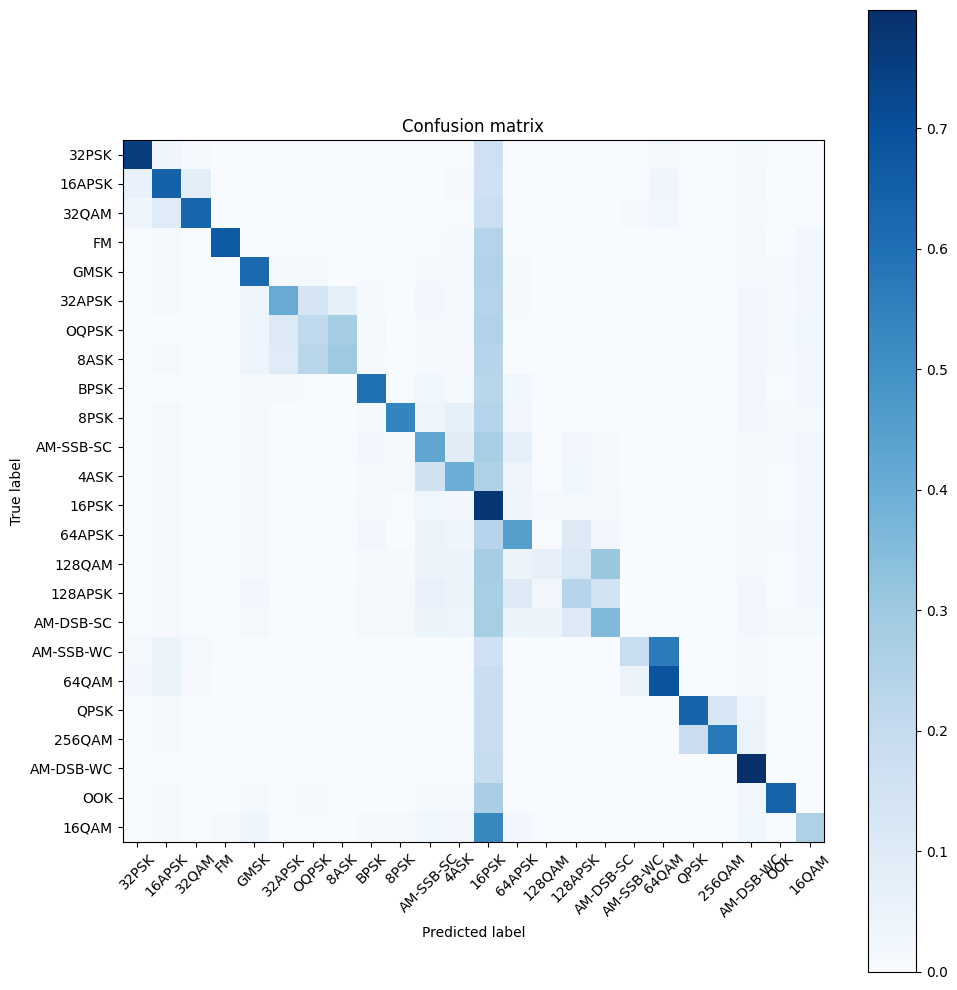

<Figure size 640x480 with 0 Axes>

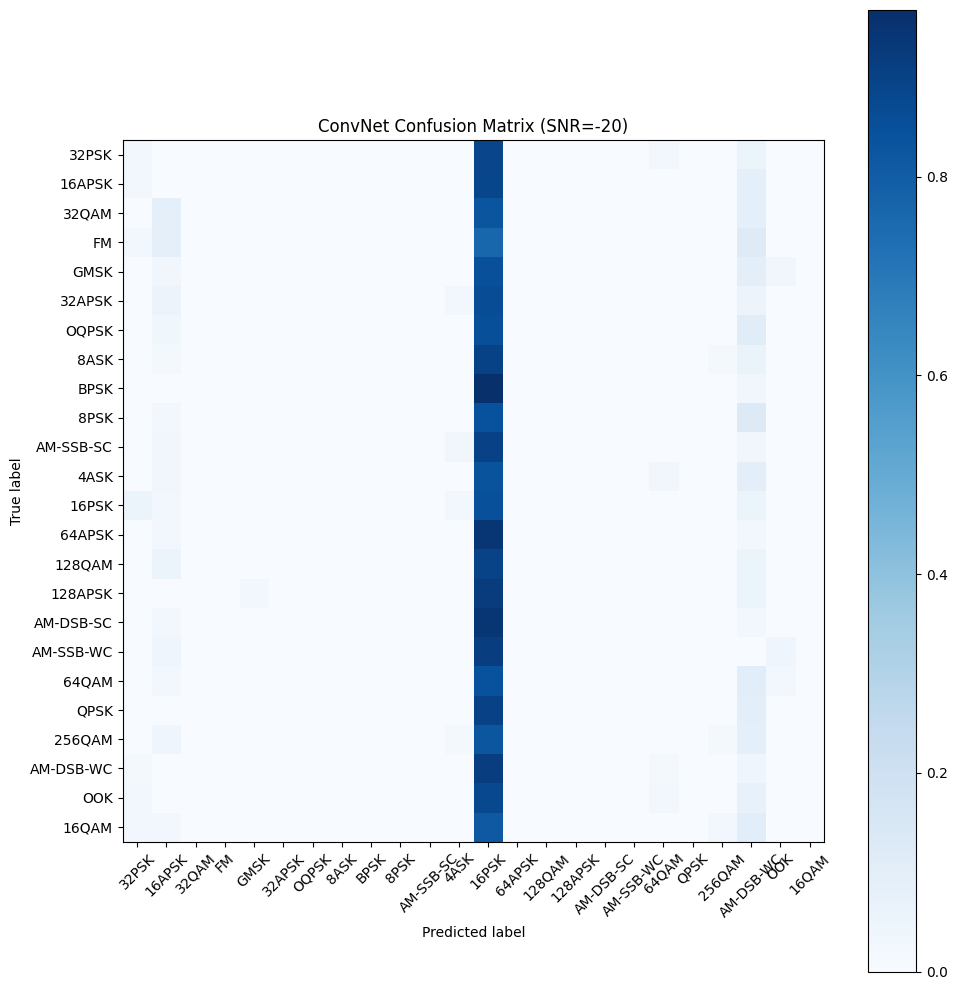

<Figure size 640x480 with 0 Axes>

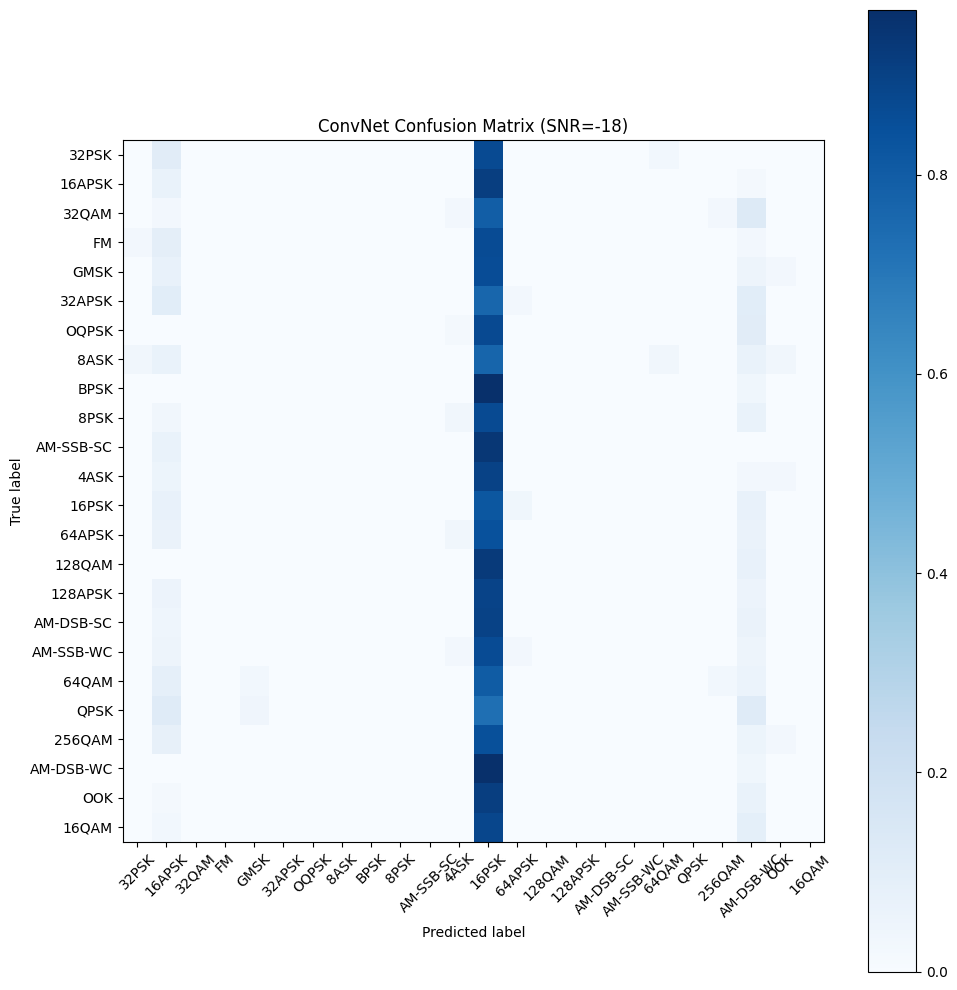

<Figure size 640x480 with 0 Axes>

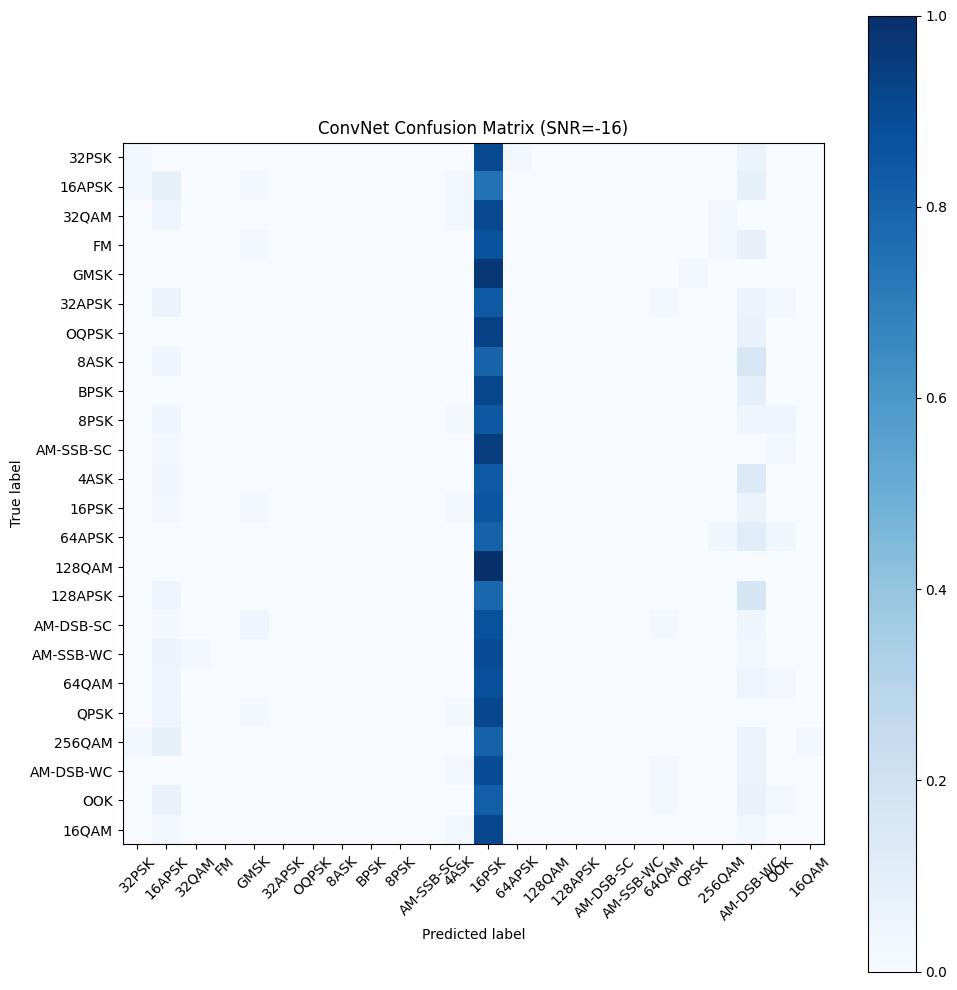

<Figure size 640x480 with 0 Axes>

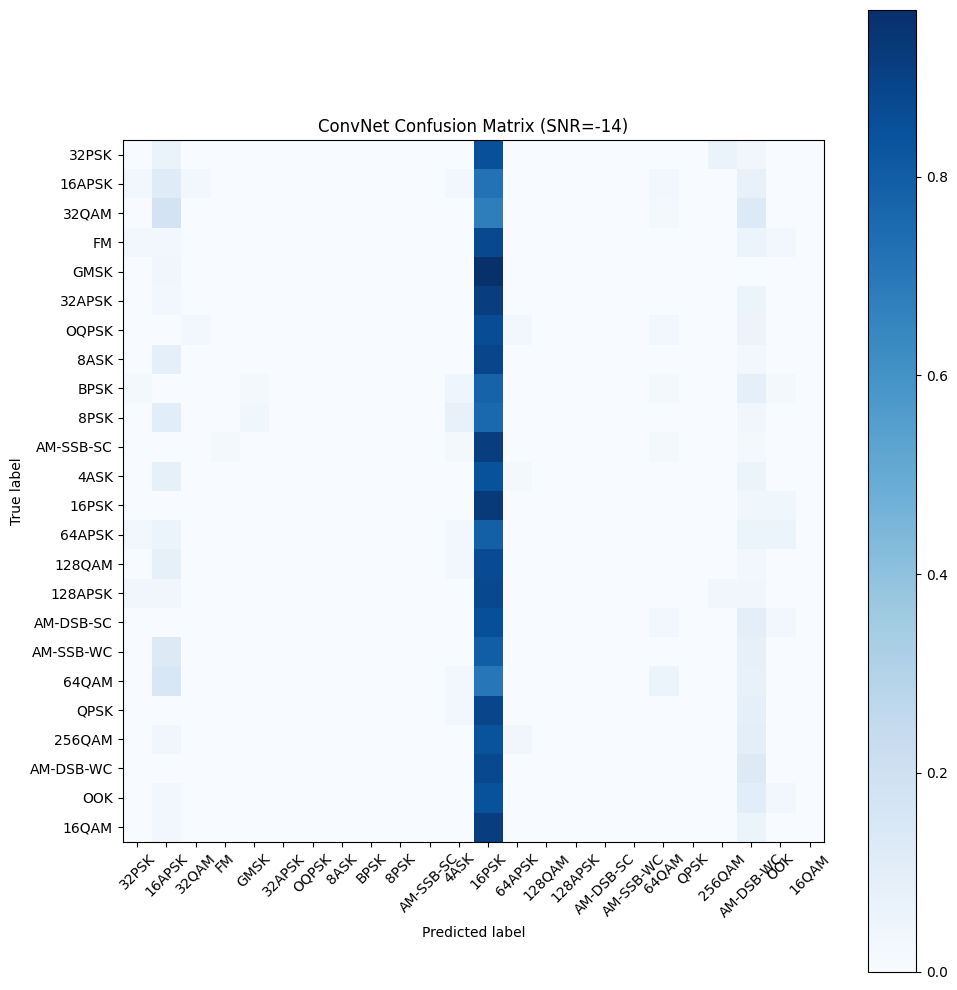

<Figure size 640x480 with 0 Axes>

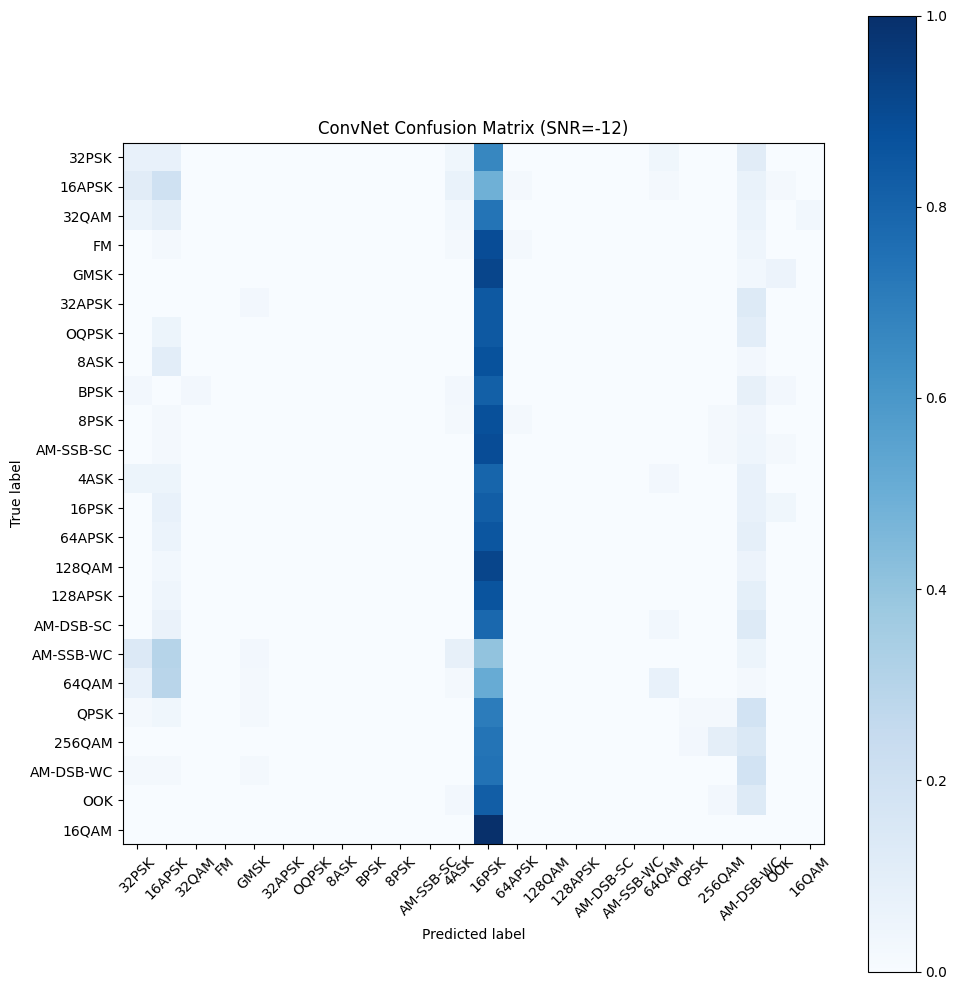

<Figure size 640x480 with 0 Axes>

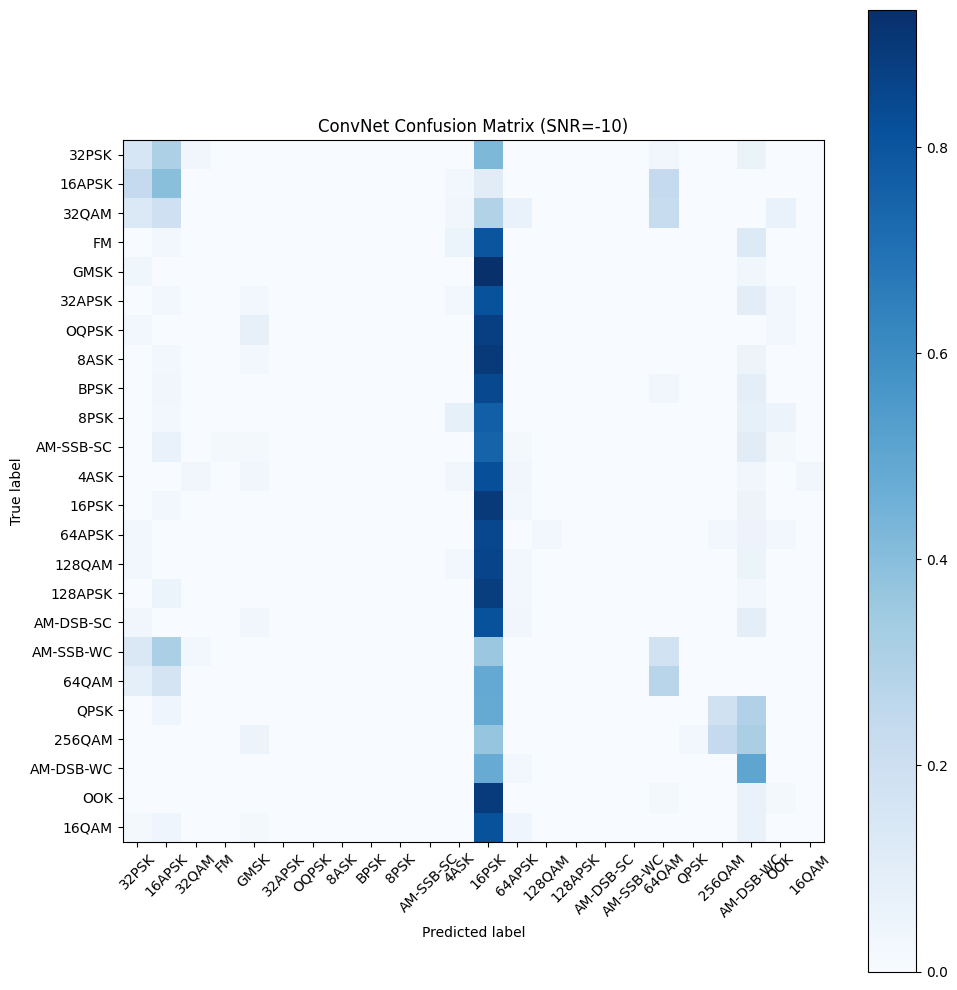

<Figure size 640x480 with 0 Axes>

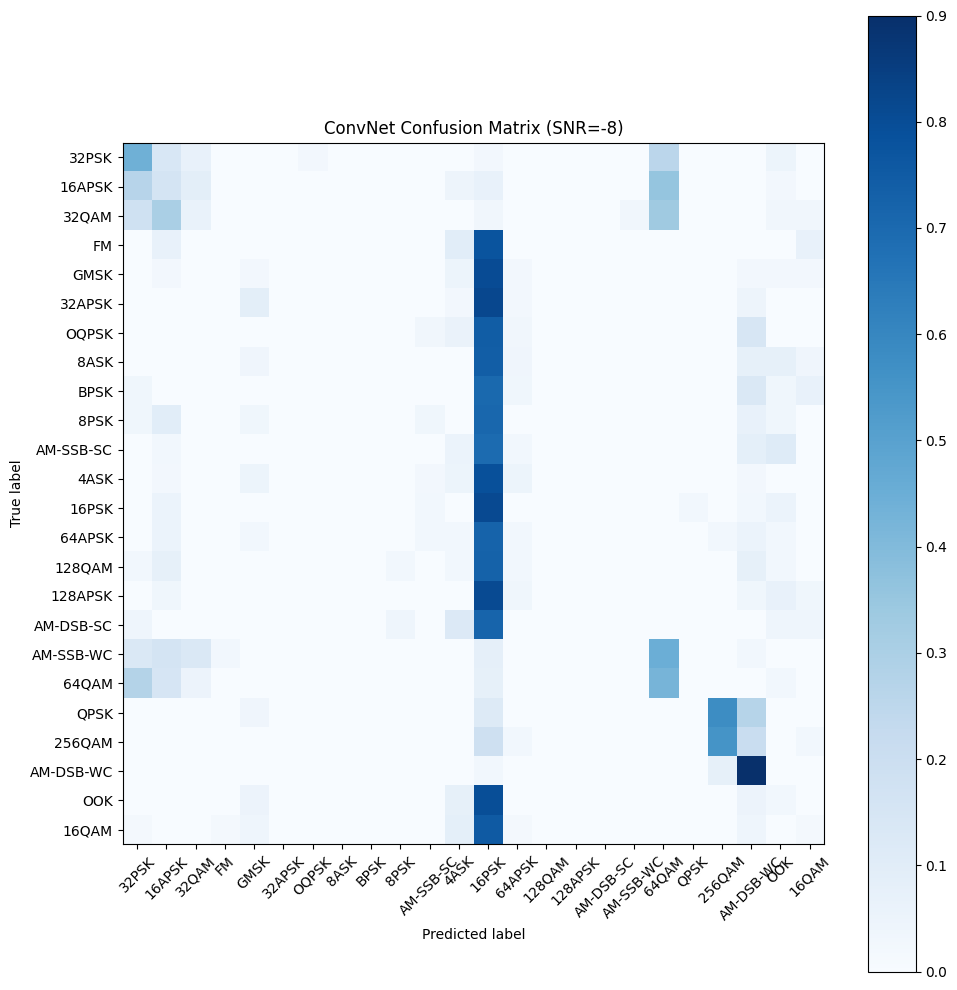

<Figure size 640x480 with 0 Axes>

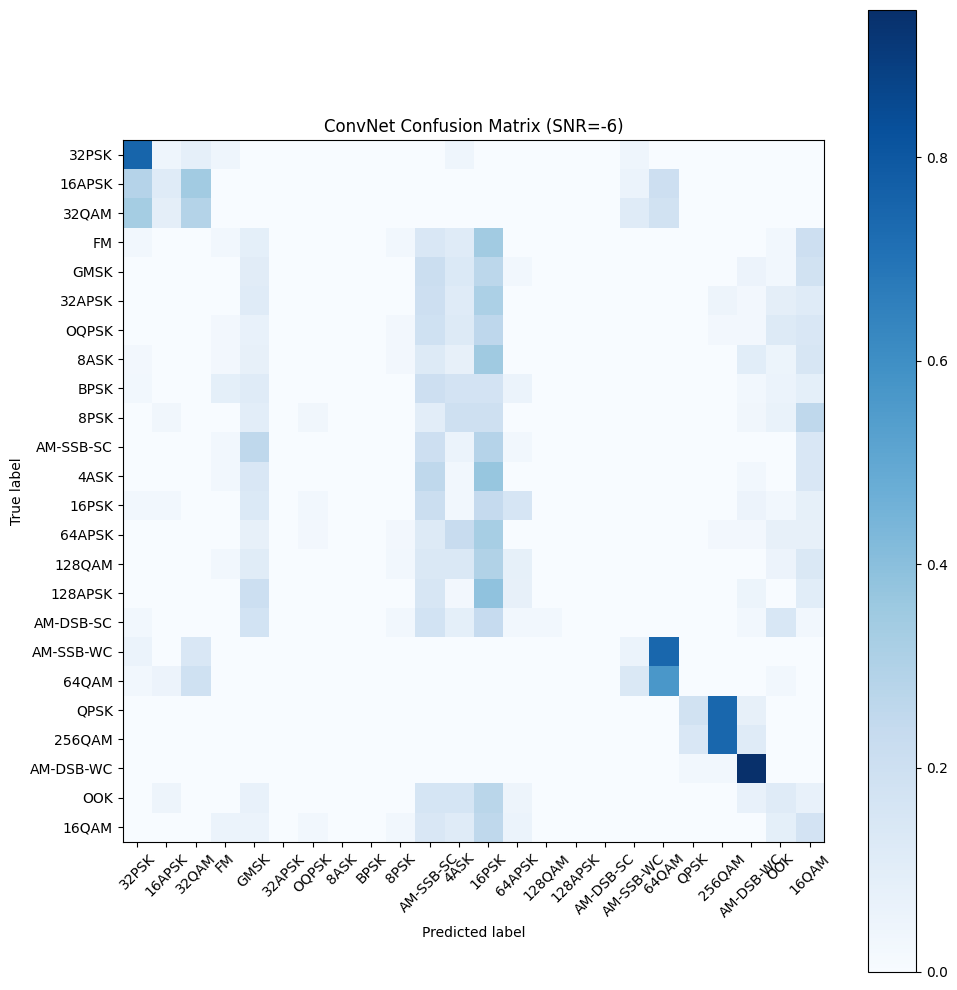

<Figure size 640x480 with 0 Axes>

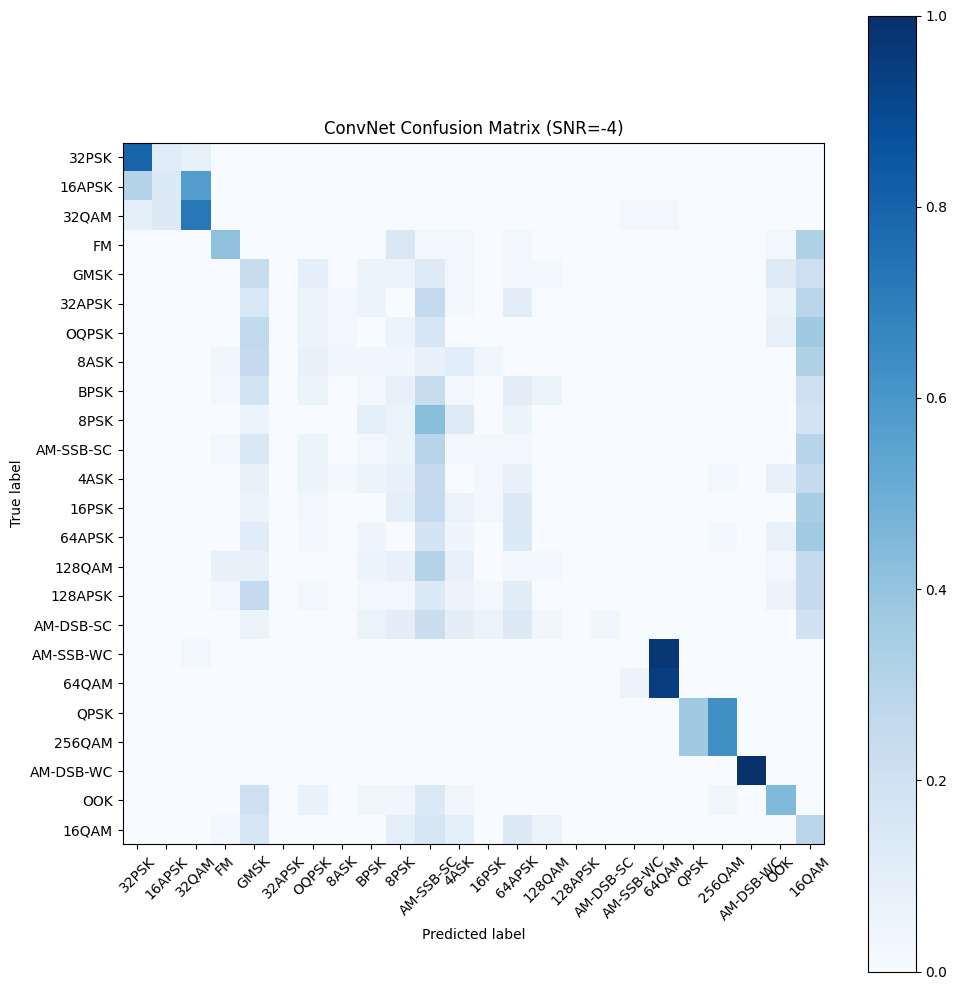

<Figure size 640x480 with 0 Axes>

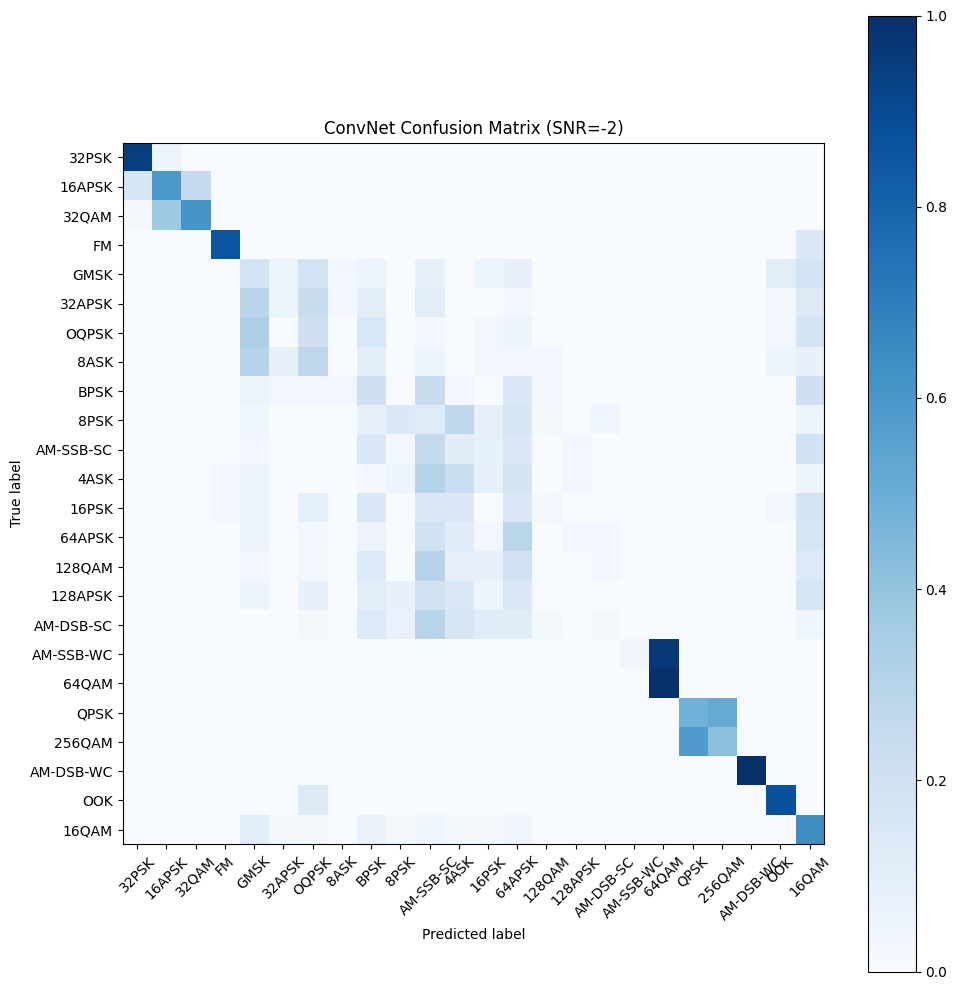

<Figure size 640x480 with 0 Axes>

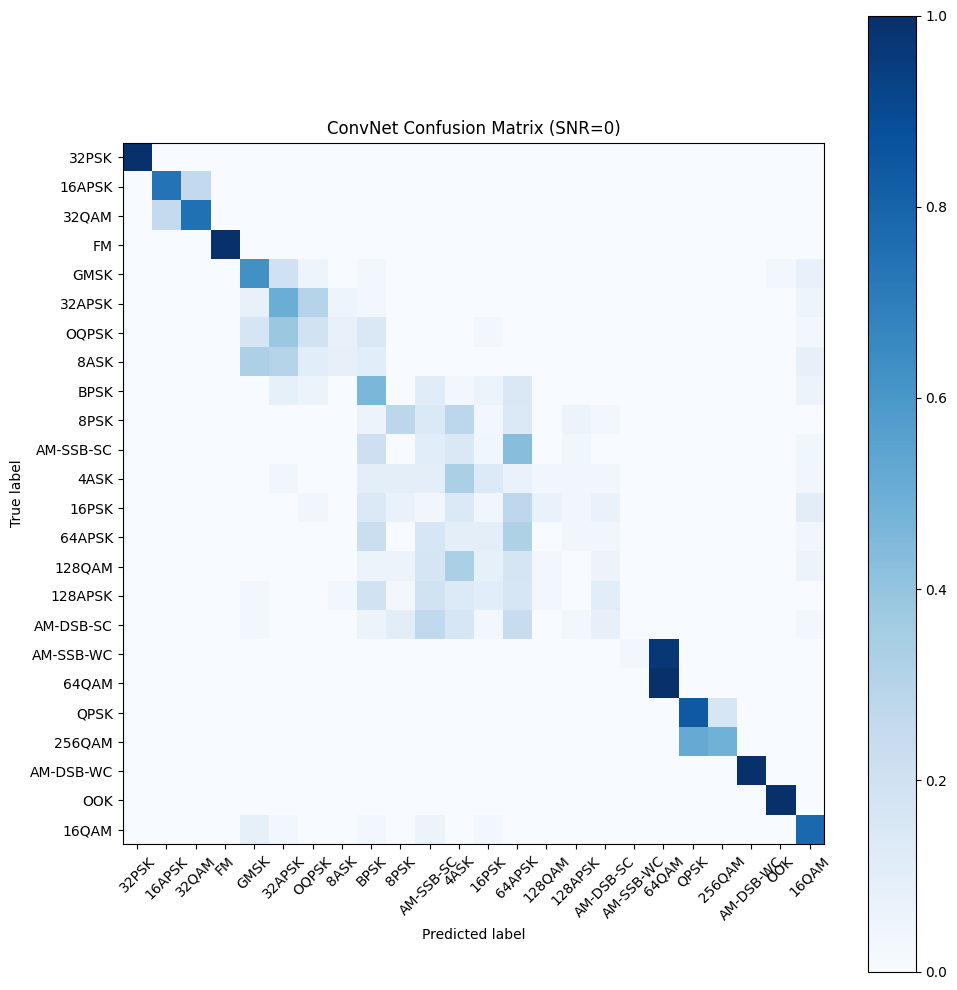

<Figure size 640x480 with 0 Axes>

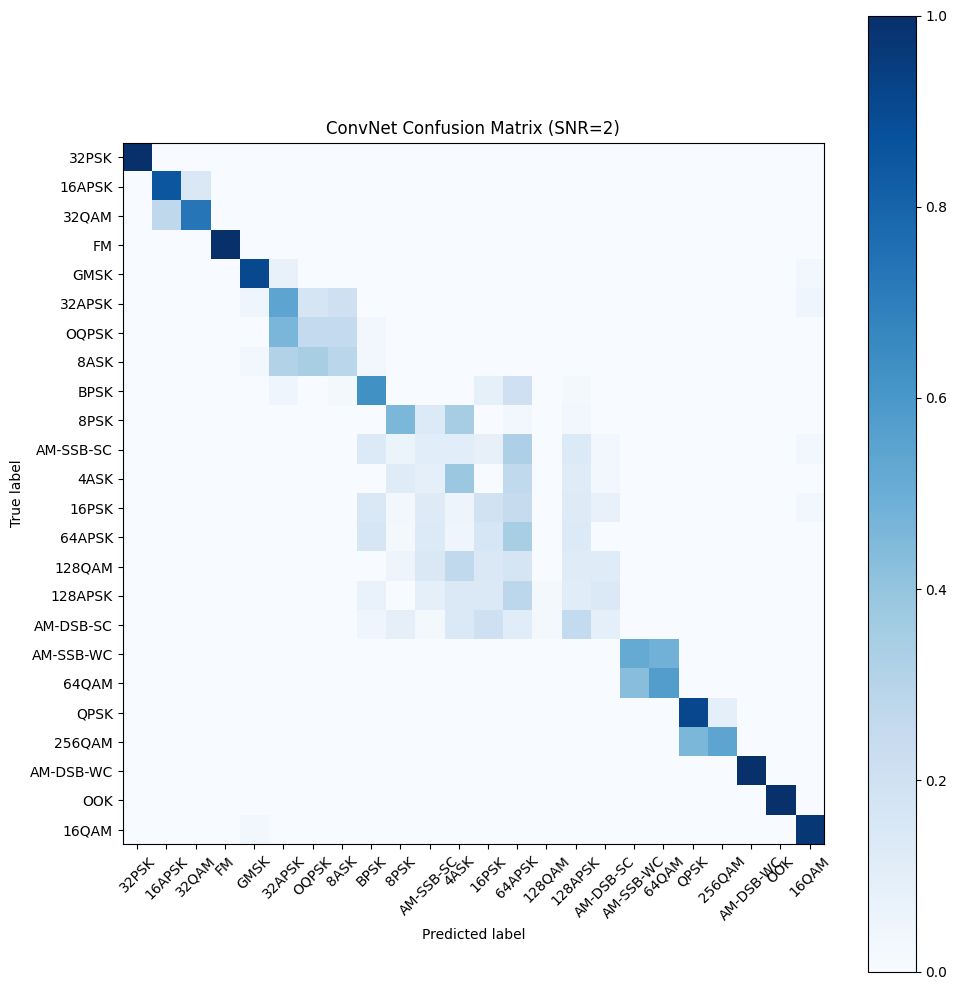

<Figure size 640x480 with 0 Axes>

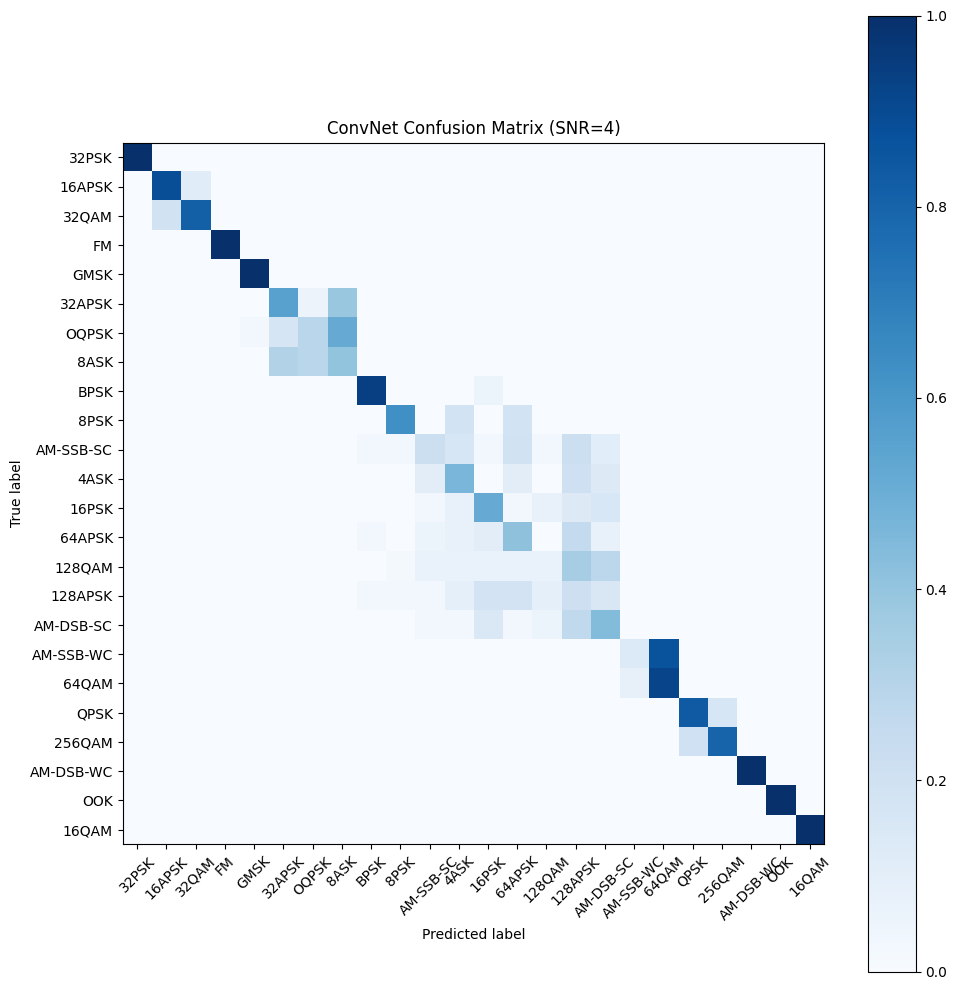

<Figure size 640x480 with 0 Axes>

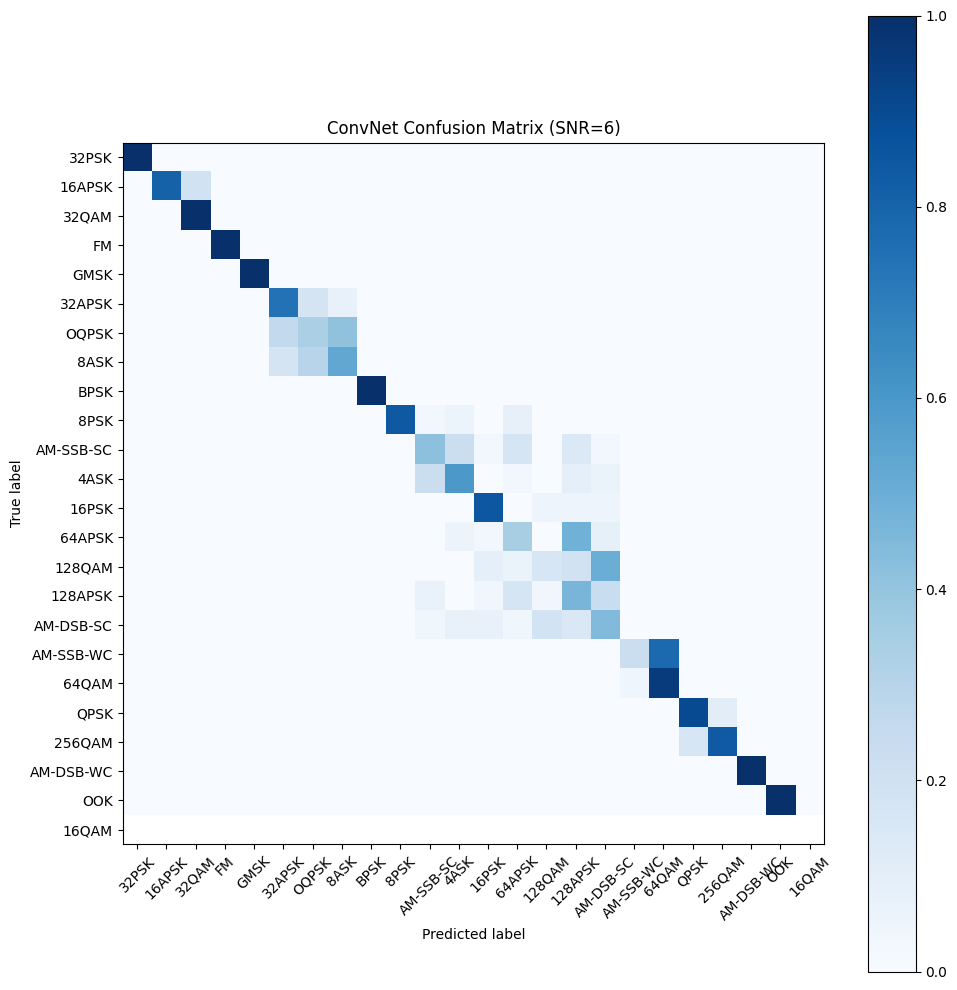

<Figure size 640x480 with 0 Axes>

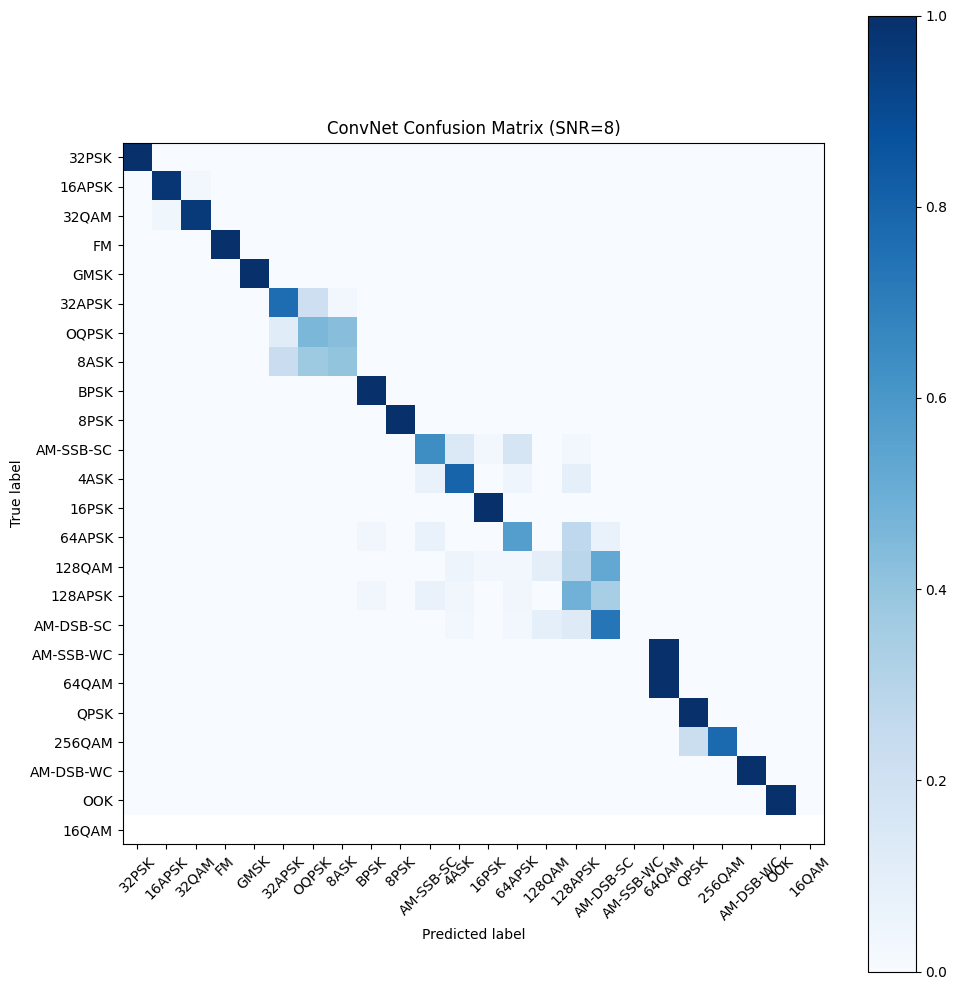

<Figure size 640x480 with 0 Axes>

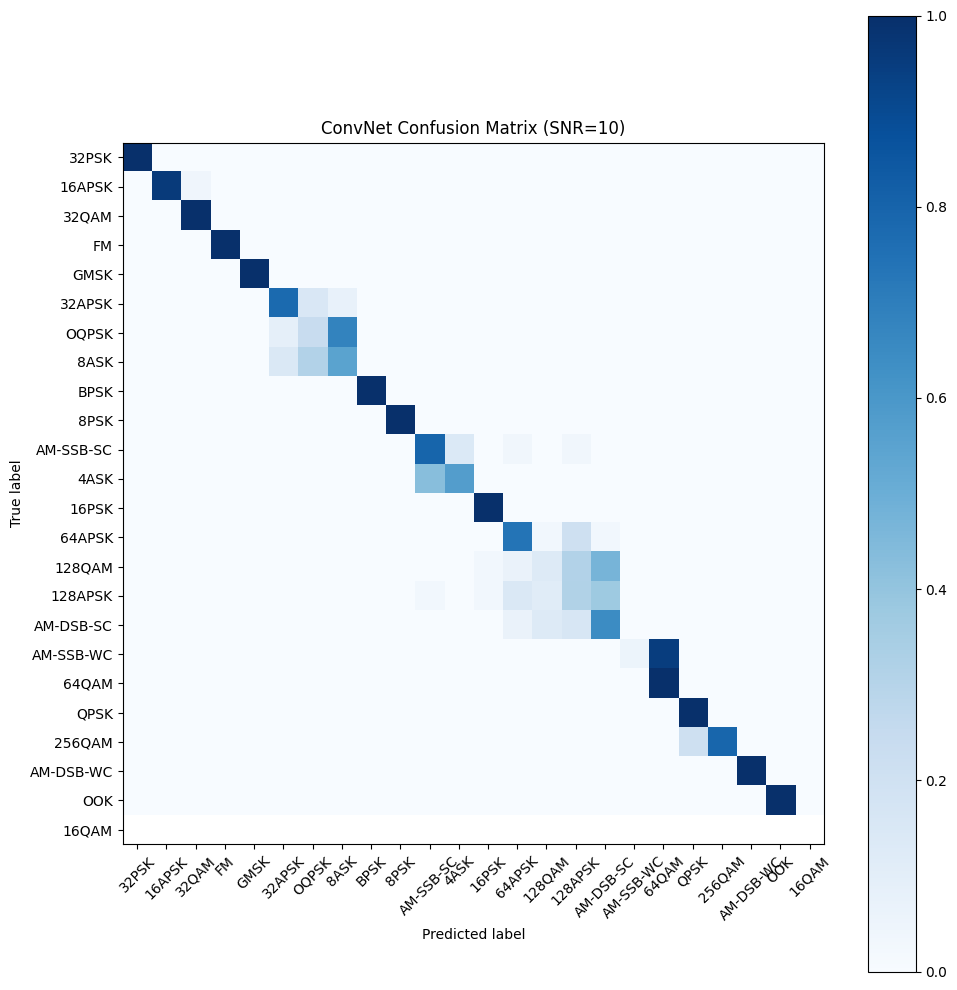

<Figure size 640x480 with 0 Axes>

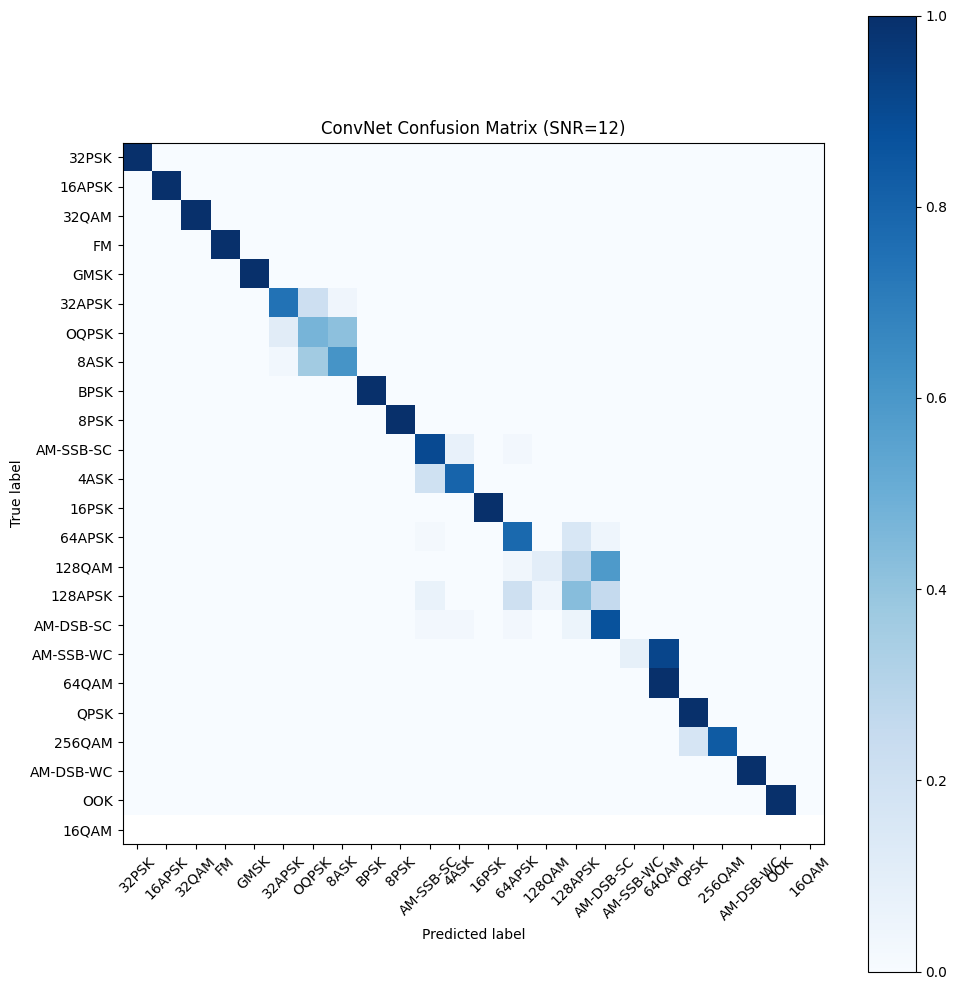

<Figure size 640x480 with 0 Axes>

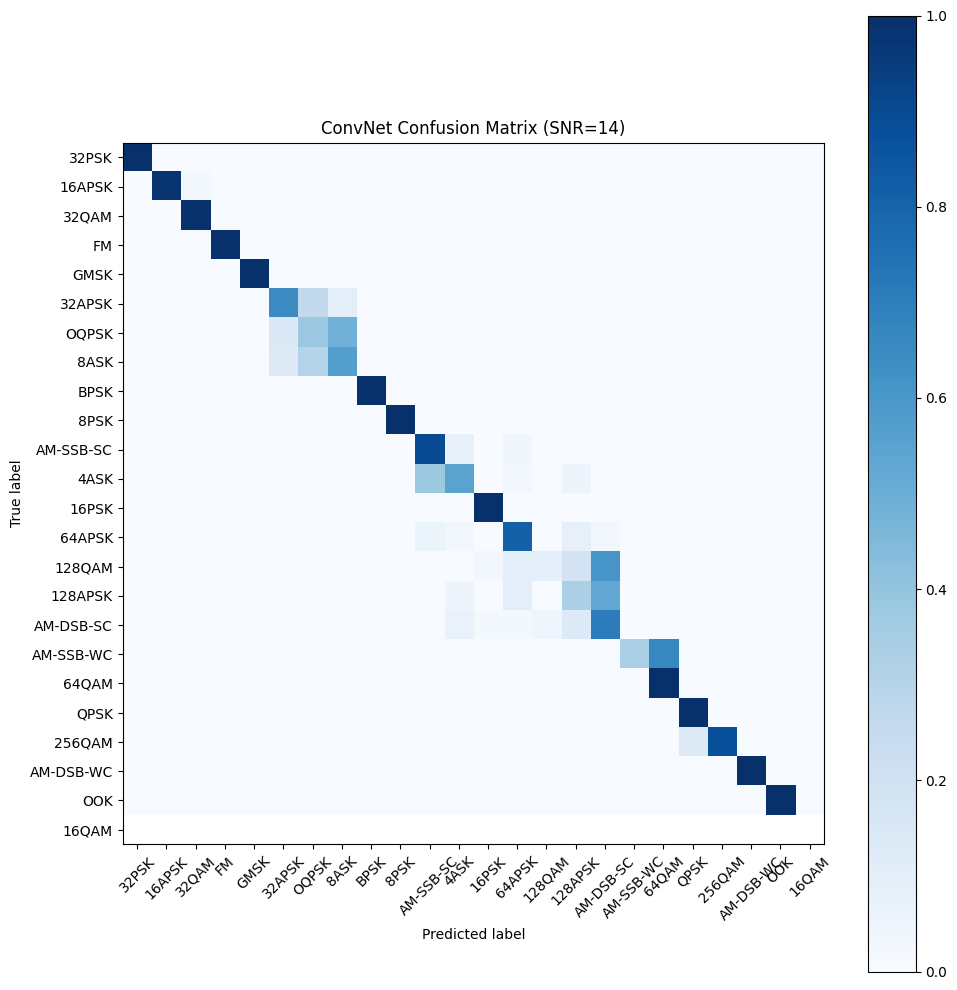

<Figure size 640x480 with 0 Axes>

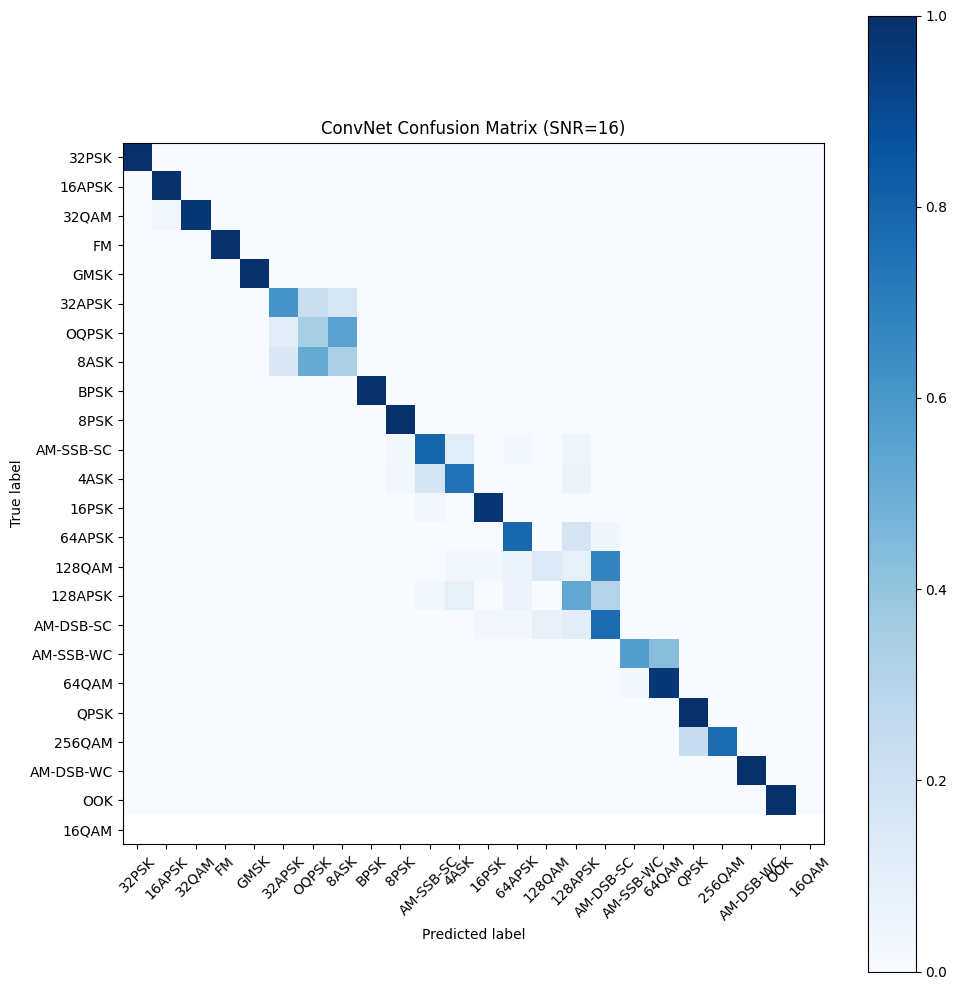

<Figure size 640x480 with 0 Axes>

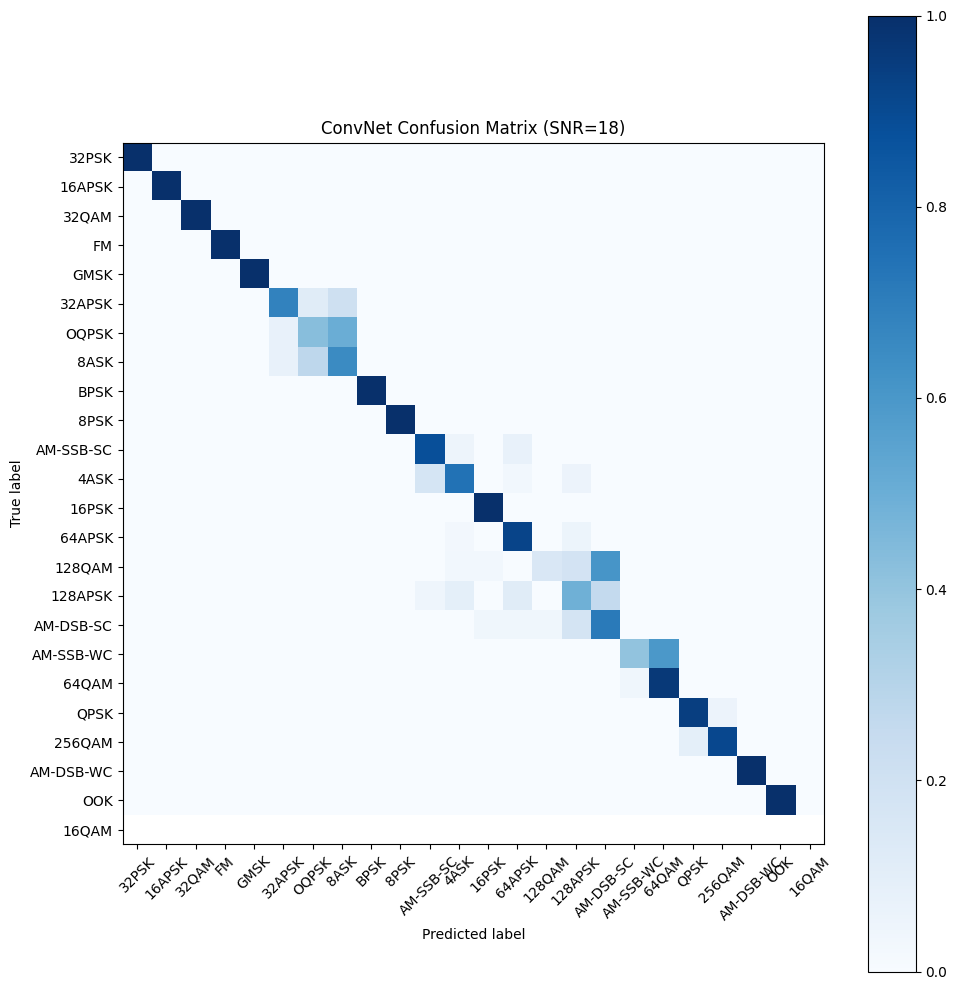

<Figure size 640x480 with 0 Axes>

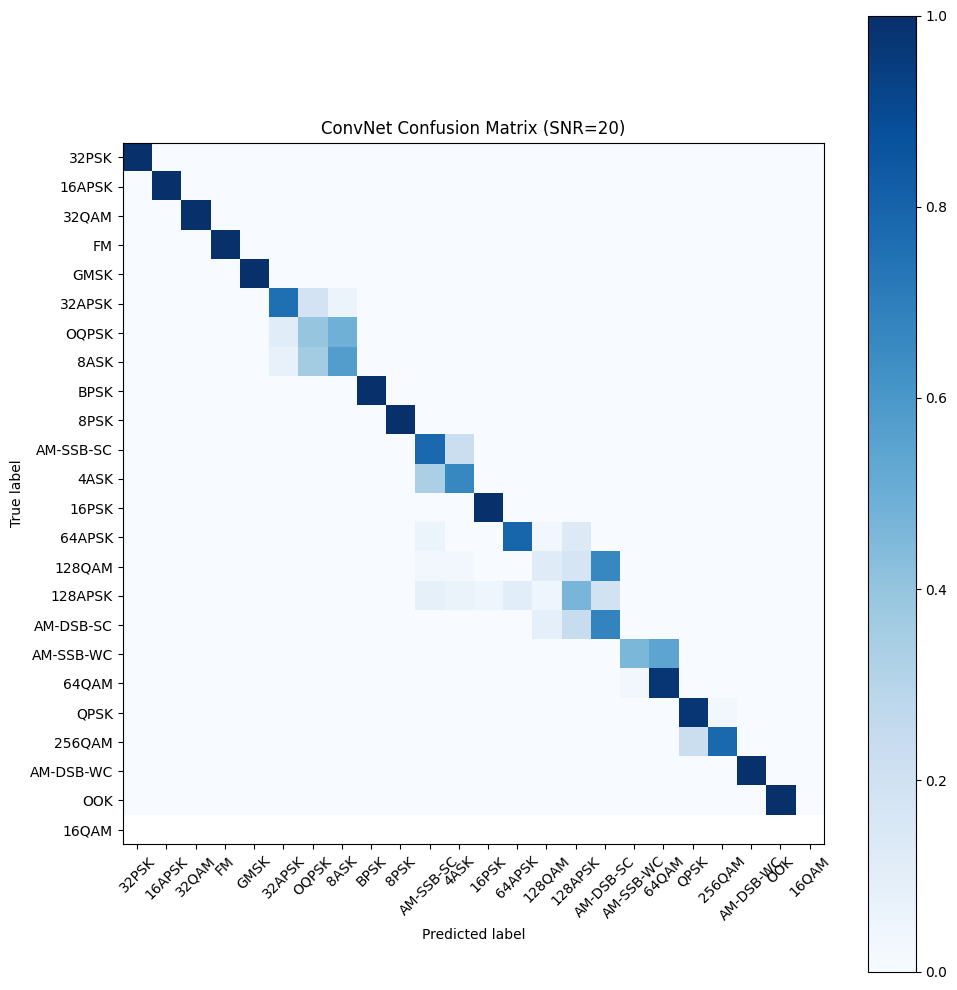

<Figure size 640x480 with 0 Axes>

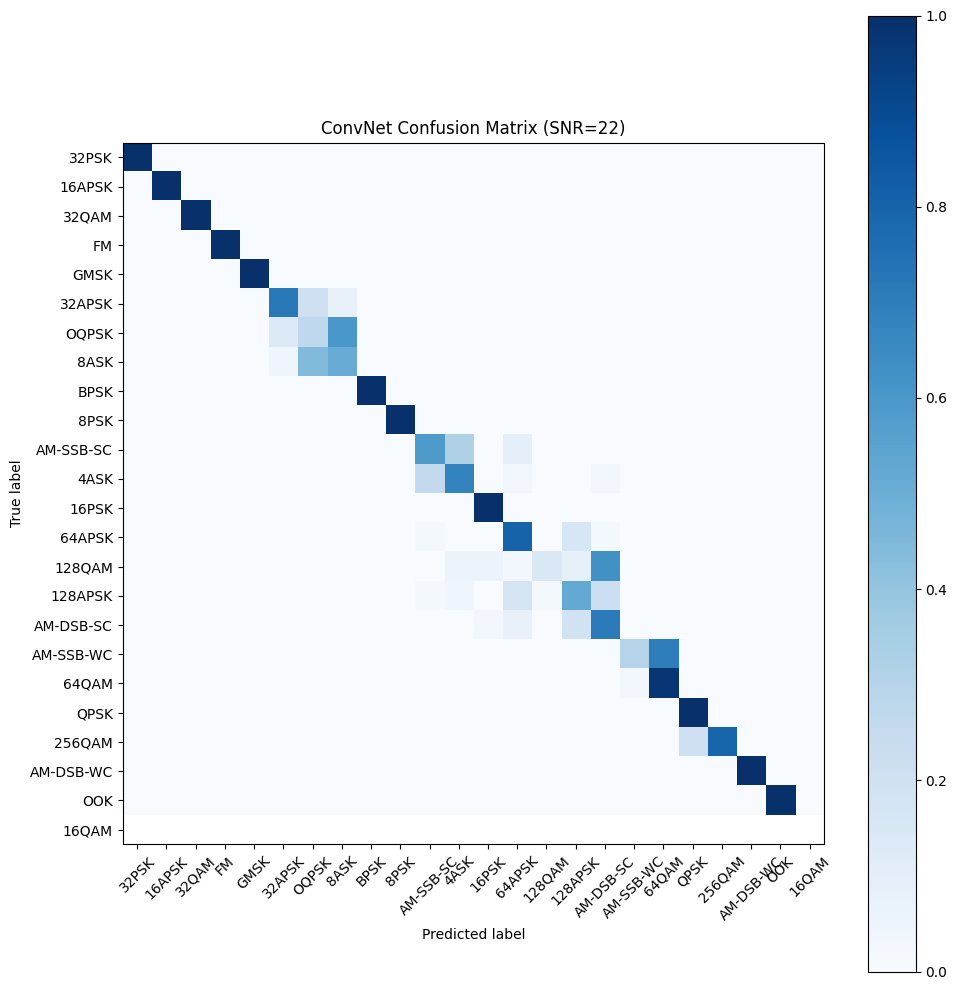

<Figure size 640x480 with 0 Axes>

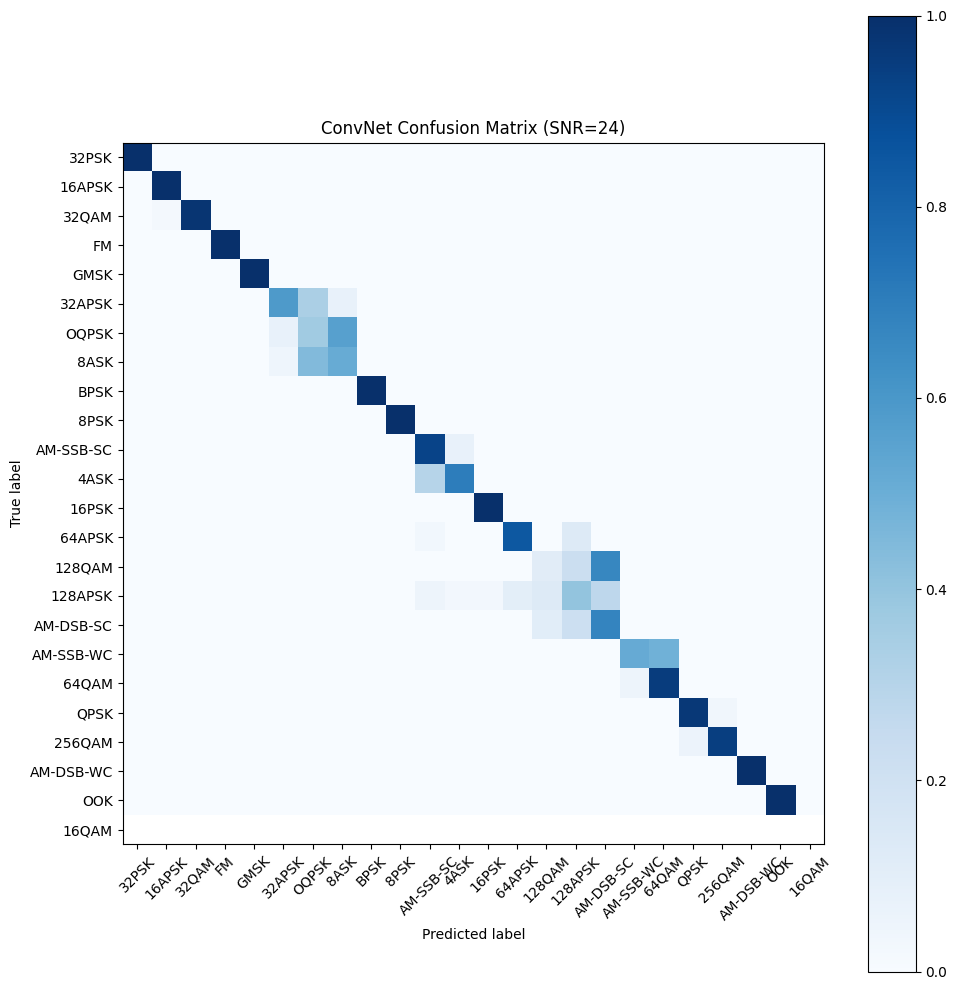

<Figure size 640x480 with 0 Axes>

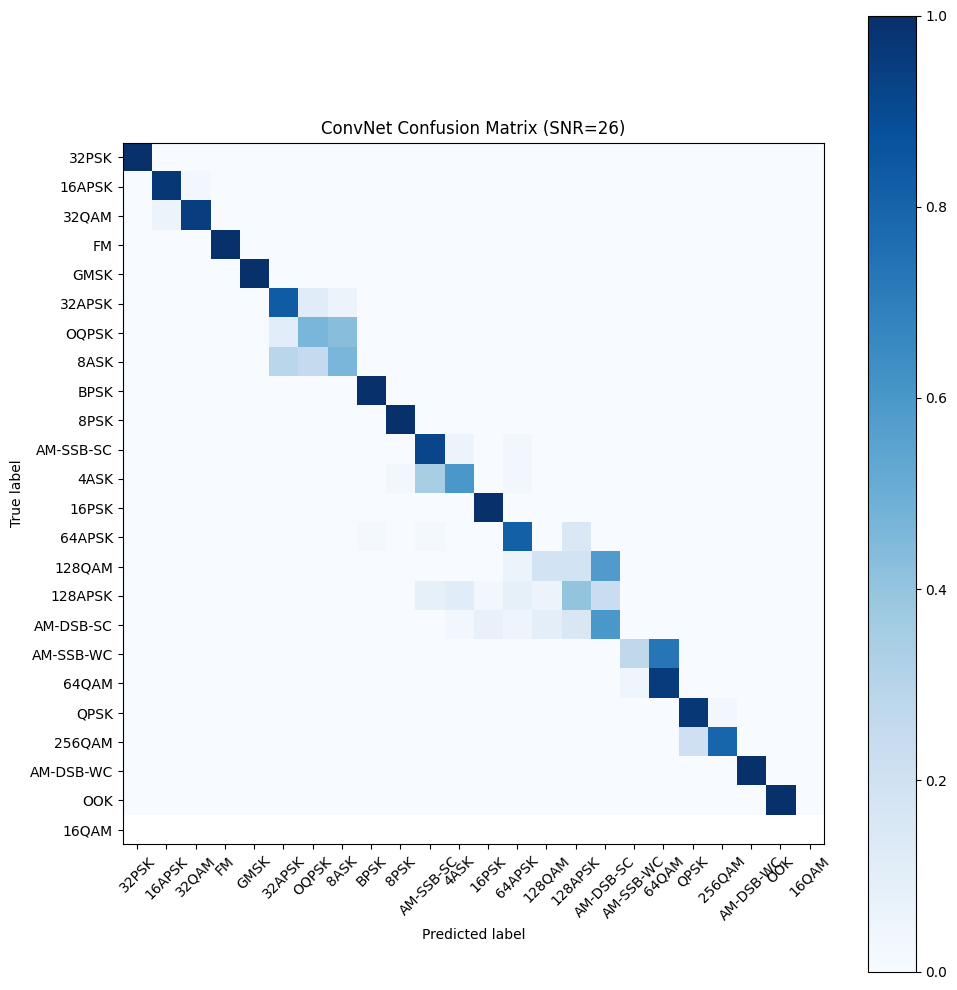

<Figure size 640x480 with 0 Axes>

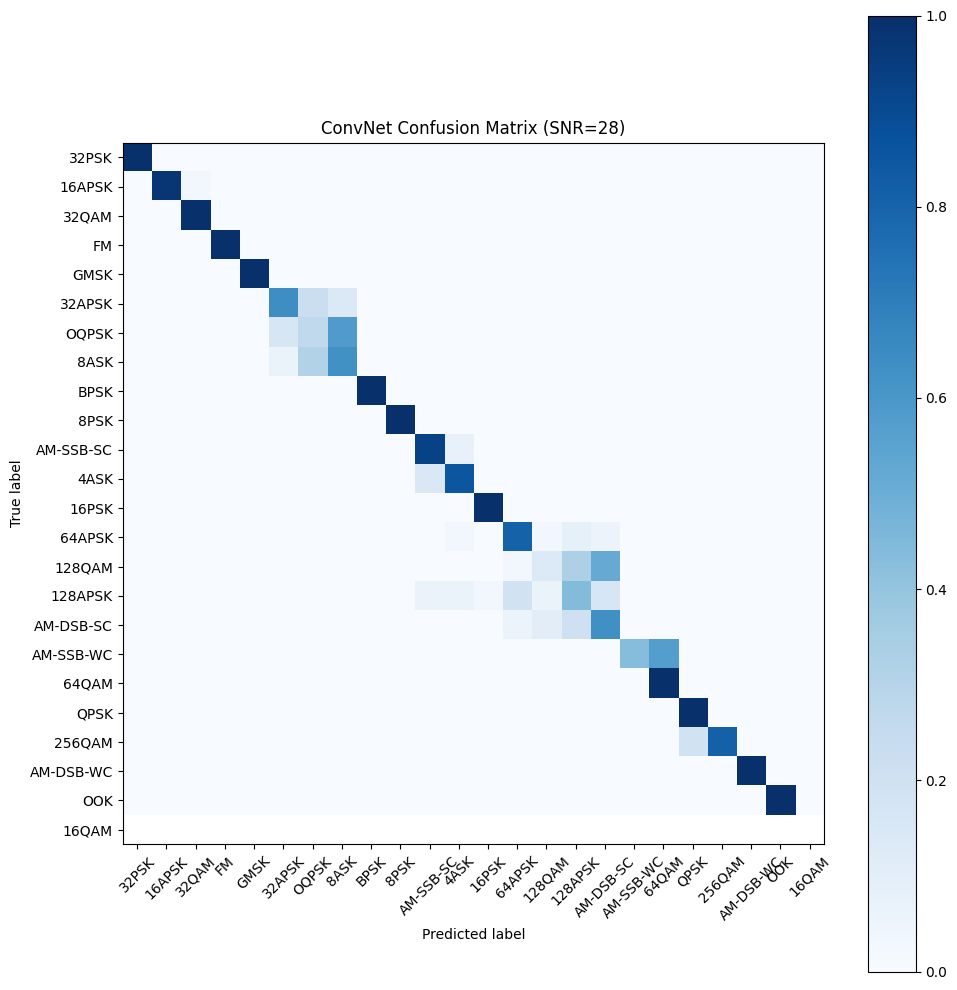

<Figure size 640x480 with 0 Axes>

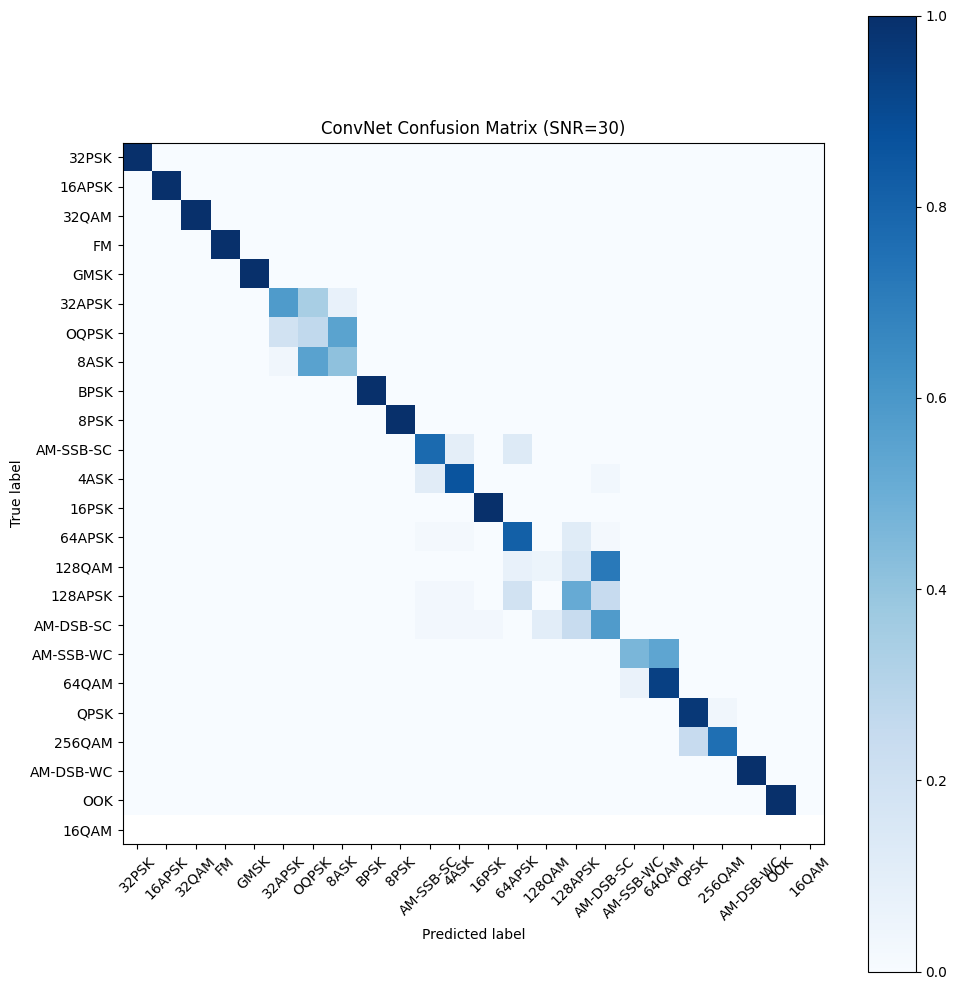

In [ ]:
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] += 1
for i in range(len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes)

# Print accuracy per class
for i in range(len(confnorm)):
    print(classes[i], confnorm[i, i])

# SNR-wise accuracy for ResNet
acc = {}
Z_test = Z_combined[test_idx].reshape((len(Z_combined[test_idx])))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test == snr]
    Y_test_snr = Y_test[Z_test == snr]

    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(X_test_snr.shape[0]):
        j = list(Y_test_snr[i, :]).index(1)
        k = int(np.argmax(pre_Y_test[i, :]))
        conf[j, k] += 1
    for i in range(len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy %s: " % snr, cor / (cor + ncor))
    acc[snr] = cor / (cor + ncor)

In [ ]:
# Smoothing the curve using interpolation
snrs = list(acc.keys())
accuracies = list(acc.values())
snr_new = np.linspace(min(snrs), max(snrs), 300)
accuracies_smooth = np.interp(snr_new, snrs, accuracies)

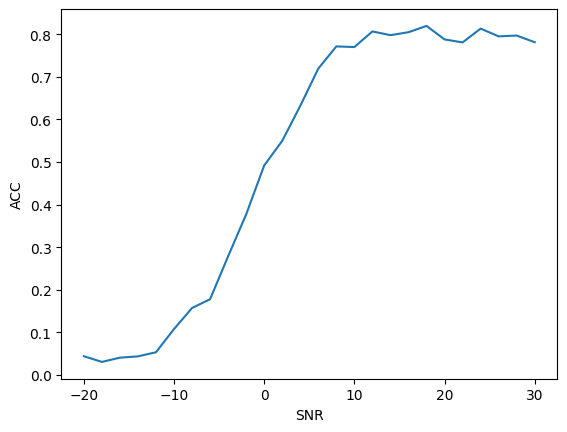

In [ ]:
# Plotting accuracy vs SNR
plt.plot(acc.keys(), acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.show()